E:\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
E:\Anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
E:\Anaconda\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future 

[LightGBM] [Info] Number of positive: 161364, number of negative: 161364
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10141
[LightGBM] [Info] Number of data points in the train set: 322728, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Validation accuracy: 0.6603459425708573
Test accuracy: 0.6608068028930135
Test precision: 0.33289301046956865
Test recall: 0.693008045485795
Test F1-score: 0.44974616840912107
Test AUC-ROC score: 0.7381643993140641


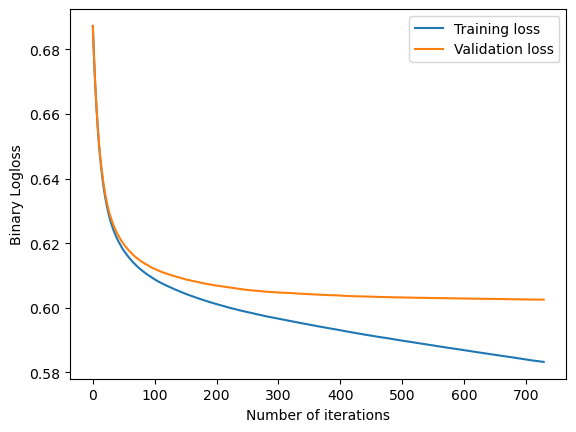

Top 15 most predictive features:
                 feature     importance
7              sub_grade  228106.075174
6                  grade  133784.966260
3                   term   30774.391809
17                   dti   20153.796853
53  acc_open_past_24mths   15419.500558
10            annual_inc   13567.750742
54           avg_cur_bal   13035.517462
15              zip_code   12675.682653
48              all_util   12505.249052
8             emp_length   12460.728152
4               int_rate   12169.775367
20        fico_range_low   12041.180121
0              loan_amnt   10719.932024
9         home_ownership   10426.620638
12               issue_d    9160.488230


In [1]:
# LOAN DEFAULT PREDICTION USING LIGHTGBM

import sys
import pandas as pd
import numpy as np

from scipy import optimize
from scipy import special
from scipy.misc import derivative



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# Read the Excel dataset into a pandas DataFrame
data = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)

def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
    a,g = alpha, gamma
    y_true = dtrain.label
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess




def separate_features(dataframe):
    categorical_features = []
    continuous_features = []

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object' or dataframe[column].dtype.name == 'category':
            categorical_features.append(column)
        elif dataframe[column].dtype == 'int64' or dataframe[column].dtype == 'float64':
            continuous_features.append(column)
        else:
            print(f'Unhandled data type in column "{column}": {dataframe[column].dtype}')

    return categorical_features, continuous_features



#print("Categorical Features:", cat_features)
#print("Continuous Features:", cont_features)


data = data[data['loan_status'].isin(['Fully Paid','Charged Off','Defaulted'])]
leakage_features = [
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'last_credit_pull_d',
    'debt_settlement_flag',
    'debt_settlement_flag_date',
    'settlement_status',
    'settlement_date',
    'settlement_amount',
    'settlement_percentage',
    'settlement_term',
    'last_fico_range_high',
    'last_fico_range_low',
    'id',
    'url',
    'emp_title',
    'title'
]

# Drop the leakage features
data = data.drop(leakage_features, axis=1)

# Calculate the percentage of missing values for each feature
missing_values = data.isnull().sum() / len(data) * 100

# Identify columns with more than 90% missing values
columns_to_drop = missing_values[missing_values > 90].index

# Drop the identified columns
data = data.drop(columns_to_drop, axis=1)

categorical_features, continuous_features = separate_features(data)
categorical_features.remove('loan_status')


data[continuous_features] = data[continuous_features].fillna(-1)

# Fill categorical NAs with "missing" and convert all elements to strings
data[categorical_features] = data[categorical_features].fillna('missing').astype(str)

data.isna().sum().sum()

#Scaling
#scaler = StandardScaler()
#data[continuous_features] = scaler.fit_transform(data[continuous_features])

for feature in categorical_features:
    label_encoder = LabelEncoder()
    data[feature] = label_encoder.fit_transform(data[feature])

# Preprocess loan status labels with custom encoding
custom_encoding = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Default': 1,
    
}
data['loan_status'] = data['loan_status'].replace(custom_encoding)


# Split the dataset into features (X) and labels (y)
X = data.drop('loan_status', axis=1)
y = data['loan_status']




# Split the dataset into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Apply RandomUnderSampler to balance the training dataset
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Scaling continuous features for the training, validation, and test sets
scaler = StandardScaler()
X_train_resampled[continuous_features] = scaler.fit_transform(X_train_resampled[continuous_features])
X_val[continuous_features] = scaler.transform(X_val[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])


# Initialize an empty dictionary to store evaluation results
evals_result = {}

#focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.8, 2)

# Create the LightGBM model
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 20,
    #'max_depth': 4,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'metric': 'binary_logloss',
    'lambda_l1': 0.01,  
    'lambda_l2': 0.01,
    
}


# Update the train_data and validation_data for the LightGBM model
train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)
validation_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Train the model
num_rounds = 1000
model = lgb.train(params, train_data, num_rounds, valid_sets=[train_data, validation_data], evals_result=evals_result, early_stopping_rounds=10, verbose_eval=False)


# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred).astype(int)

# Calculate the test accuracy
test_accuracy =accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1_score = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)


# Calculate the validation accuracy
y_pred_val = model.predict(X_val)
y_pred_val_binary = np.round(y_pred_val).astype(int)
val_accuracy = accuracy_score(y_val, y_pred_val_binary)

# Compare the validation accuracy and test accuracy
print(f"Validation accuracy: {val_accuracy}")
print(f"Test accuracy: {test_accuracy}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1-score: {test_f1_score}")
print(f"Test AUC-ROC score: {test_auc_roc}")


# Plot the learning curves
import matplotlib.pyplot as plt

# Extract the binary logloss values for training and validation sets
train_loss = evals_result['training']['binary_logloss']
valid_loss = evals_result['valid_1']['binary_logloss']

# Create a plot with training and validation loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.xlabel('Number of iterations')
plt.ylabel('Binary Logloss')
plt.legend()
plt.show()


# Save the model
model.save_model('loan_default_prediction_lightgbm.txt')

# Get feature importances
importance = model.feature_importance(importance_type='gain')

# Create a DataFrame for feature names and their corresponding importance scores
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importance})

# Sort the DataFrame by the importance score in descending order
sorted_feature_importance = feature_importance_df.sort_values(by='importance', ascending=False)

# Display the top 5 most predictive features
print("Top 15 most predictive features:")
print(sorted_feature_importance.head(15))


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


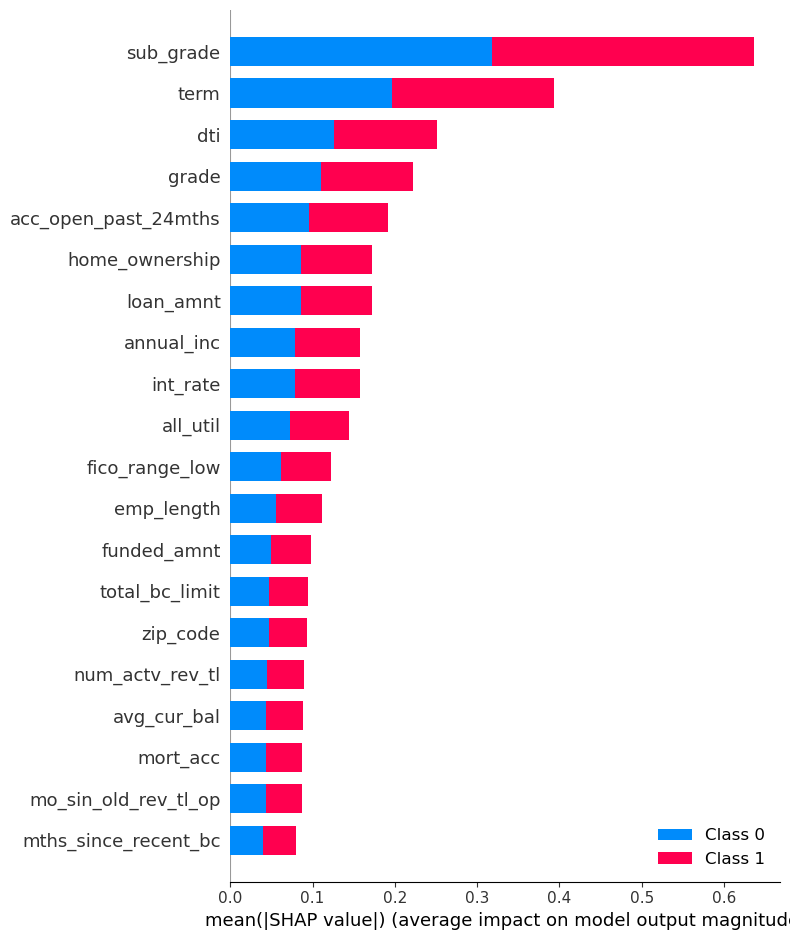

TypeError: list indices must be integers or slices, not tuple

In [2]:
import shap

# Create the explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_type="bar")





# Visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


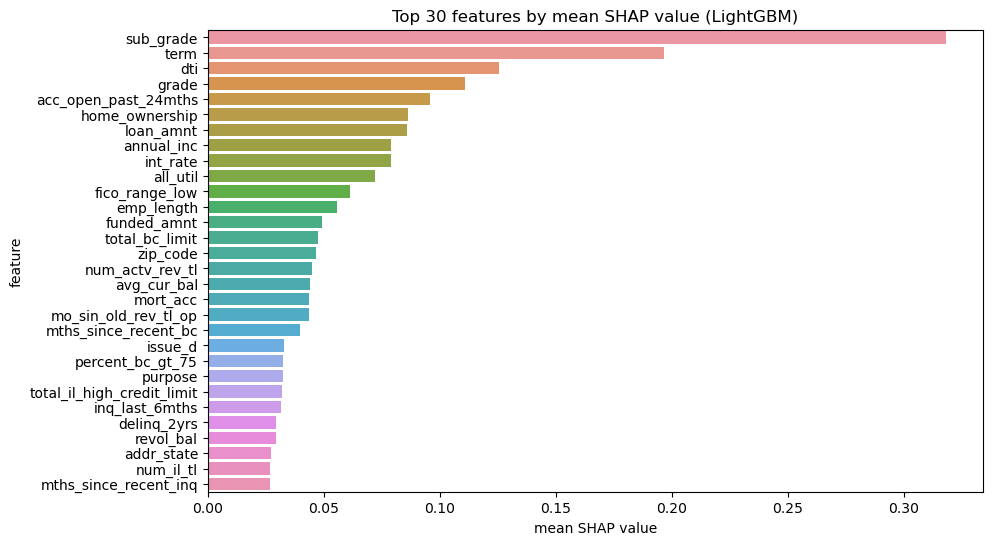

Feature: sub_grade, Mean SHAP Value: 0.31807881521391873
Feature: term, Mean SHAP Value: 0.19640455189371675
Feature: dti, Mean SHAP Value: 0.12567036551035105
Feature: grade, Mean SHAP Value: 0.11071390858722942
Feature: acc_open_past_24mths, Mean SHAP Value: 0.09584983787509577
Feature: home_ownership, Mean SHAP Value: 0.08617137409534742
Feature: loan_amnt, Mean SHAP Value: 0.08582982485687261
Feature: annual_inc, Mean SHAP Value: 0.07900089843142874
Feature: int_rate, Mean SHAP Value: 0.07881600625017655
Feature: all_util, Mean SHAP Value: 0.07206340495495415
Feature: fico_range_low, Mean SHAP Value: 0.06114993264726832
Feature: emp_length, Mean SHAP Value: 0.05574400180534933
Feature: funded_amnt, Mean SHAP Value: 0.04920408938199169
Feature: total_bc_limit, Mean SHAP Value: 0.047350378391609445
Feature: zip_code, Mean SHAP Value: 0.04664875024943721
Feature: num_actv_rev_tl, Mean SHAP Value: 0.04484375114698651
Feature: avg_cur_bal, Mean SHAP Value: 0.04391844539636971
Feature: m

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Get mean absolute SHAP values for each feature
shap_sum = (np.abs(shap_values[0]).mean(axis=0) + np.abs(shap_values[1]).mean(axis=0)) / 2  # average of the SHAP values for the two classes

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'feature': X_test.columns, 'mean SHAP value': shap_sum})

# Sort features by mean SHAP value
importance_df = importance_df.sort_values('mean SHAP value', ascending=False)

# Only take the top N
top_N = 30
top_features = importance_df.iloc[:top_N]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='mean SHAP value', y='feature', orient='h')
plt.title(f'Top {top_N} features by mean SHAP value (LightGBM)')
plt.show()

for idx, row in top_features.iterrows():
    print(f"Feature: {row['feature']}, Mean SHAP Value: {row['mean SHAP value']}")



In [6]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, log_loss, confusion_matrix

cm = confusion_matrix(y_test, y_pred_binary)

def print_confusion_matrix(confusion_matrix, class_names):
    cm_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    cm_df.index.name = 'Actual (True)'
    cm_df.columns.name = 'Predicted'
    
    print("Confusion Matrix:")
    print("\n".join(["{}{}{}".format(a, " " * (22 - len(a)), b) for a, b in zip(cm_df.index, cm_df.to_numpy())]))
    print("\nTN (True Negative): {}".format(confusion_matrix[0][0]))
    print("FP (False Positive): {}".format(confusion_matrix[0][1]))
    print("FN (False Negative): {}".format(confusion_matrix[1][0]))
    print("TP (True Positive): {}".format(confusion_matrix[1][1]))

class_names = ['Charged Off/Default', 'Fully Paid']
print_confusion_matrix(cm, class_names)

Confusion Matrix:
Charged Off/Default   [140501  74742]
Fully Paid            [16522 37297]

TN (True Negative): 140501
FP (False Positive): 74742
FN (False Negative): 16522
TP (True Positive): 37297
